In [1]:
from __future__ import print_function, division
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import torch.nn.functional as F
from tqdm import tqdm, tqdm_notebook
from PIL import Image
import matplotlib.pyplot as plt
import time
import os

plt.ion()   # interactive mode
multiGPU = False

%matplotlib inline

In [2]:
TRAIN_IMG_PATH = "../input/train/Train/"
TEST_IMG_PATH = "../input/test/Test/"
LABELS_CSV_PATH = "../input/train.csv"
SAMPLE_SUB_PATH = "../input/test.csv"

In [3]:
class CactusDataset(Dataset):
    """Cactus identification dataset."""

    def __init__(self, img_dir, dataframe, transform=None):
        """
        Args:
            img_dir (string): Directory with all the images.        
            dataframe (pandas.core.frame.DataFrame): Pandas dataframe obtained
                by read_csv().
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.labels_frame = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.labels_frame.ID[idx]) 
        image = Image.open(img_name)
        label = self.labels_frame.Class[idx]

        if self.transform:
            image = self.transform(image)

        return [image, label] 

In [4]:
agedict = {'YOUNG':0 , 'MIDDLE' :1 , 'OLD':2}

dframe = pd.read_csv(LABELS_CSV_PATH)
dframe = dframe.replace({"Class": agedict})
cut = int(len(dframe)*0.95)

0
Shape of the image is:  (82, 102)


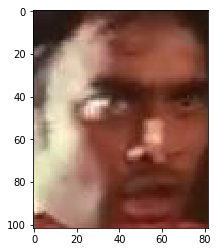

In [5]:
train, test = np.split(dframe, [cut], axis=0)
test = test.reset_index(drop=True)

train_ds = CactusDataset(TRAIN_IMG_PATH, train)
test_ds = CactusDataset(TRAIN_IMG_PATH, test)
idx = 1
plt.imshow(train_ds[idx][0])
print(train_ds[idx][1])
print("Shape of the image is: ", train_ds[idx][0].size)

In [6]:
data_transform = transforms.Compose([
        transforms.RandomResizedCrop(32),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
    ])

In [7]:
train_ds = CactusDataset(TRAIN_IMG_PATH, train, data_transform)
test_ds = CactusDataset(TRAIN_IMG_PATH, test, data_transform)
datasets = {"train": train_ds, "val": test_ds}

idx = 29
print(train_ds[idx][1])
print("Shape of the image is: ", train_ds[idx][0].shape)

0
Shape of the image is:  torch.Size([3, 32, 32])


In [8]:
trainloader = DataLoader(train_ds, batch_size=32,
                        shuffle=True, num_workers=0)

testloader = DataLoader(test_ds, batch_size=4,
                        shuffle=True, num_workers=0)

dataloaders = {"train": trainloader, "val": testloader}

In [9]:
num_epochs = 25
num_classes = 3
batch_size = 128
learning_rate = 0.002
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in tqdm_notebook(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:     
            since_epoch = time.time()
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode
    
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in tqdm_notebook(dataloaders[phase]):
                # get the inputs
                inputs, labels = data

                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(datasets[phase])
            epoch_acc = running_corrects.double() / len(datasets[phase])

            time_elapsed_epoch = time.time() - since_epoch
            print('{} Loss: {:.4f} Acc: {:.4f} in {:.0f}m {:.0f}s'.format(
                phase, epoch_loss, epoch_acc, time_elapsed_epoch // 60, time_elapsed_epoch % 60))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    return model

In [11]:
class CactiCNN(nn.Module):
    def __init__(self):
        # ancestor constructor call
        super(CactiCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 10, 3,1,(1,1))
        self.conv = nn.Conv2d(10, 30, 3,1,(1,1))
        self.batch_0=nn.BatchNorm2d(30)
        self.conv2 = nn.Conv2d(30, 60, 3)
        self.batch_1=nn.BatchNorm2d(60)
        self.fc1 = nn.Linear(7*7*60, 500)
        self.batch_2=nn.BatchNorm1d(500)
        self.fc2 = nn.Linear(500, 300)
        self.batch_3=nn.BatchNorm1d(300)
        self.fc3 = nn.Linear(300, 100)
        self.fc4 = nn.Linear(100, 10)
   
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.batch_0(self.conv(x)))
        x = F.relu(self.batch_1(self.conv2(x)))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 7*7*60)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [12]:
model = CactiCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [13]:
model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler,
                           num_epochs=num_epochs)

Epoch 0/24
----------


train Loss: 0.9372 Acc: 0.5419 in 0m 28s


val Loss: 0.9137 Acc: 0.5612 in 0m 2s

Epoch 1/24
----------


train Loss: 0.8932 Acc: 0.5823 in 0m 22s


val Loss: 0.8855 Acc: 0.5803 in 0m 1s

Epoch 2/24
----------


train Loss: 0.8740 Acc: 0.5975 in 0m 22s


val Loss: 0.8627 Acc: 0.5984 in 0m 1s

Epoch 3/24
----------


train Loss: 0.8601 Acc: 0.6090 in 0m 21s


val Loss: 0.8570 Acc: 0.6004 in 0m 1s

Epoch 4/24
----------


train Loss: 0.8441 Acc: 0.6159 in 0m 22s


val Loss: 0.8707 Acc: 0.6074 in 0m 1s

Epoch 5/24
----------


train Loss: 0.8138 Acc: 0.6286 in 0m 22s


val Loss: 0.8243 Acc: 0.6325 in 0m 1s

Epoch 6/24
----------


train Loss: 0.8065 Acc: 0.6326 in 0m 22s


val Loss: 0.8122 Acc: 0.6426 in 0m 1s

Epoch 7/24
----------


train Loss: 0.8021 Acc: 0.6334 in 0m 21s


val Loss: 0.7972 Acc: 0.6466 in 0m 1s

Epoch 8/24
----------


train Loss: 0.8014 Acc: 0.6353 in 0m 22s


val Loss: 0.8010 Acc: 0.6486 in 0m 1s

Epoch 9/24
----------


train Loss: 0.7897 Acc: 0.6478 in 0m 22s


val Loss: 0.8034 Acc: 0.6345 in 0m 1s

Epoch 10/24
----------


train Loss: 0.7844 Acc: 0.6469 in 0m 21s


val Loss: 0.8169 Acc: 0.6476 in 0m 1s

Epoch 11/24
----------


train Loss: 0.7853 Acc: 0.6430 in 0m 21s


val Loss: 0.8205 Acc: 0.6345 in 0m 1s

Epoch 12/24
----------


train Loss: 0.7828 Acc: 0.6472 in 0m 21s


val Loss: 0.8057 Acc: 0.6406 in 0m 1s

Epoch 13/24
----------


train Loss: 0.7836 Acc: 0.6463 in 0m 21s


val Loss: 0.8175 Acc: 0.6315 in 0m 1s

Epoch 14/24
----------


In [14]:
submission_df = pd.read_csv(SAMPLE_SUB_PATH)
output_df = pd.DataFrame(index=submission_df.index, columns=submission_df.keys() )
output_df['ID'] = submission_df['ID']
submission_df['Class'] =  [0] * len(submission_df)


In [15]:
tdata_transform = transforms.Compose([
        transforms.CenterCrop(32),
        transforms.ToTensor(),
])

submission_ds = CactusDataset(TEST_IMG_PATH, submission_df, tdata_transform)

sub_loader = DataLoader(submission_ds, batch_size=1,
                        shuffle=False, num_workers=0)

In [16]:
def test_sumission(model):
    since = time.time()
    sub_outputs = []
    model.train(False)  # Set model to evaluate mode
    # Iterate over data.
    prediction = []
    for data in sub_loader:
        # get the inputs
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        prediction.append(int(pred))
      
    time_elapsed = time.time() - since
    print('Run complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return prediction

In [17]:
newdict = {0:'YOUNG' ,1:'MIDDLE', 2:'OLD'}

In [18]:
sub = pd.read_csv('../input/test.csv')
sub['Class'] =  [0]*len(sub)
sub['Class'] = test_sumission(model_ft)
sub = sub.replace({"Class": newdict})
sub.to_csv('submission1.csv', index= False)

Run complete in 0m 19s
